# Modelo Keras secuencial


*   5 capas ocultas densas de 500, 1000, 1000, 2000, 2000 unidades
*   Activación LeakyReLU(alpha=0.1)
*   Loss MSLE
*   Métrica MAE
*   Adam Learning Rate 1e-6
*   2000 epochs



In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import LeakyReLU
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.model_selection import train_test_split
from datetime import datetime

PATH = r'/content/drive/My Drive/Colab Notebooks/'
PATH_MODELS= r'/content/drive/My Drive/Colab Notebooks/models/'
DATA_INPUT_FILE= r'data_h2o_HF_ccpvdz.csv'
OUTPUT_FILES = r'seq_3cv32'

# Carga de datos
17636 registros

In [5]:
data= pd.read_csv(PATH + DATA_INPUT_FILE, index_col= 0)
data.describe()

,rh1,rh2,ang,energia
count,17636.000000,17636.000000,17636.000000,17636.000000
mean,1.718462,1.718462,104.482706,-75.741635
std,0.465277,0.465277,4.329904,0.428579
min,0.800000,0.800000,94.500000,-76.027388
25%,1.400000,1.400000,102.500000,-75.992674
50%,1.708000,1.708000,104.500000,-75.924886
75%,2.025000,2.025000,106.500000,-75.722473
max,2.800000,2.800000,114.500000,-72.066162


# Transformación de las variables para el entrenamiento
*   x_input: Se normalizan las variables predictoras
*   y_input: Se le resta el mínimo a la variable objetivo


In [6]:
#Se normalizan las variables predictoras
x = data[['ang', 'rh1', 'rh2']].copy()
x_describe= x.describe()
x_stats = x_describe.transpose()
x_input = (x - x_stats['mean']) / x_stats['std']

# Se le resta el mínimo a la variable objetivo
minimo=min(data['energia'])
y_input = data['energia'].copy() -minimo


# Creación de los conjuntos de train y validacción
Conjunto de validación del 10%

In [7]:
x_train, x_valid, y_train, y_valid = train_test_split(x_input, y_input , random_state = 33, test_size = 0.1)

# Definición de la arquitectura

In [ ]:
#Modelo
model = keras.Sequential([
    layers.Dense(500, activation=LeakyReLU(alpha=0.1), input_shape=[len(x_train.keys())]),
    layers.Dense(1000, activation=LeakyReLU(alpha=0.1)),
    layers.Dense(1000, activation=LeakyReLU(alpha=0.1)),
    layers.Dense(2000, activation=LeakyReLU(alpha=0.1)),
    layers.Dense(2000, activation=LeakyReLU(alpha=0.1)),
    layers.Dense(1)
  ])

#Optimizador 
optimizer = keras.optimizers.Adam(learning_rate=1e-6)

model.compile( loss='mean_squared_logarithmic_error',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               2000      
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              501000    
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dense_3 (Dense)              (None, 2000)              2002000   
_________________________________________________________________
dense_4 (Dense)              (None, 2000)              4002000   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2001      
Total params: 7,510,001
Trainable params: 7,510,001
Non-trainable params: 0
______________________________________________

# Callback

In [ ]:
#Se guarda el mejor modelo según la métrica de referencia MAE
callback_mejor_modelo = tf.keras.callbacks.ModelCheckpoint(
    filepath= PATH_MODELS + OUTPUT_FILES + r'_best.h5',
    monitor='val_mae',
    mode='min',
    save_best_only=True)

# Entrenamiento

In [ ]:
EPOCHS = 2000

datetime_comienzo = datetime.now()

#Entrenamiento
history = model.fit(
  x_train, y_train, verbose=0, 
  epochs=EPOCHS, validation_data=(x_valid, y_valid)
  ,callbacks=[callback_mejor_modelo])

datetime_fin = datetime.now()

#Se guarda el modelo
model.save(PATH_MODELS + OUTPUT_FILES + r'.h5',include_optimizer=True, save_format='h5')

print("Tiempo de entrenamiento:" + str(datetime_fin-datetime_comienzo) )

#Historia de entrenamiento a dataframe
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.to_csv(PATH_MODELS + 'hist' + OUTPUT_FILES + r'.h5',index=True)
hist.tail(5) 

Tiempo de entrenamiento:0:44:56.155349


,loss,mae,mse,val_loss,val_mae,val_mse,epoch
1995,0.000025,0.001990,0.000204,0.000005,0.001836,0.000018,1995
1996,0.000026,0.001824,0.000212,0.000016,0.003720,0.000066,1996
1997,0.000025,0.001950,0.000196,0.000020,0.004032,0.000089,1997
1998,0.000025,0.002098,0.000197,0.000003,0.001238,0.000012,1998
1999,0.000025,0.001801,0.000209,0.000006,0.001833,0.000028,1999


# Cargamos el mejor modelo
Y comprobamos que la evaluación corresponde a la mejor época de la métrica de referencia MAE

In [9]:
model_best = keras.models.load_model(PATH_MODELS + OUTPUT_FILES + r'_best.h5',
                                      custom_objects = {"LeakyReLU": LeakyReLU})
model_best.evaluate(x_valid, y_valid, verbose=2)

56/56 - 0s - loss: 3.1211e-06 - mean_absolute_error: 9.7463e-04 - mean_squared_error: 1.1857e-05


[3.1210588531394023e-06, 0.0009746329742483795, 1.185726432595402e-05]

# Inferencia - Energía frente a una distancia de enlace
Fijando la otra distancia de enlace a 1.808 ua y el ángulos a 104.5 grados

Tiempo de entrenamiento:0:00:00.074963


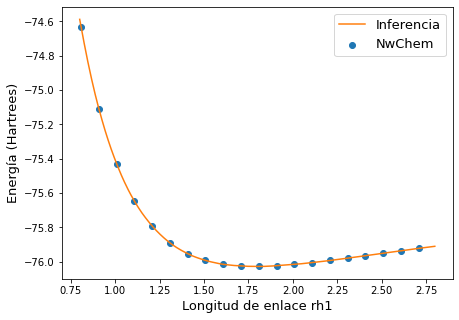

In [12]:
x_long_enlace = data[(np.round(data["ang"],1)==104.5) & (np.round(data["rh2"],3)==1.808)].copy()
y_long_enlace =x_long_enlace.pop("energia")


x_arange = pd.DataFrame()
x_arange['rh1'] =np.arange(0.8, 2.8, 0.001)
x_arange['rh2'] =1.808
x_arange['ang']= 104.5
x_arange_input = (x_arange - x_stats['mean']) / x_stats['std']

datetime_comienzo = datetime.now()
test_predictions_arrange_rh1 = model_best.predict(x_arange_input).flatten()
datetime_fin = datetime.now()
print("Tiempo de entrenamiento:" + str(datetime_fin-datetime_comienzo) )

fig, ax = plt.subplots(figsize=(7,5))
ax.plot(x_arange['rh1'], test_predictions_arrange_rh1 + minimo,'r-', label='Inferencia',  color='tab:orange')
ax.scatter(x_long_enlace['rh1'], y_long_enlace, label='NwChem')

ax.set_xlabel('Longitud de enlace rh1', fontsize=13)
ax.set_ylabel('Energía (Hartrees)', fontsize=13)
ax.legend(fontsize=13)
plt.show()

# Inferencia - Energía frente al ángulo
Fijando las dos distancias de enelace a 1.808

Ángulo en el vértice de la parábola: 104.77


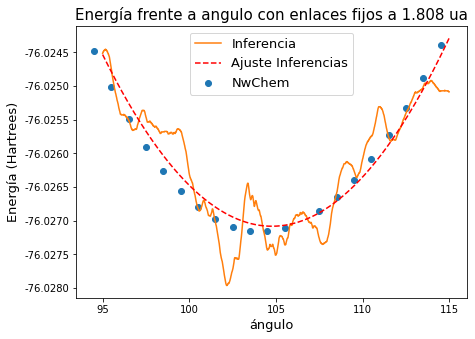

In [14]:
x_data_ang = data[(np.round(data['rh1'],3)==1.808) & (np.round(data['rh2'],3)==1.808)].copy()
y_data_ang =x_data_ang.pop("energia")

x_arange = pd.DataFrame()
x_arange['ang']= np.arange(95, 115, 0.01)
x_arange['rh1'] =1.808
x_arange['rh2'] =1.808
x_arange_input = (x_arange - x_stats['mean']) / x_stats['std']

test_predictions_arrange_ang = model_best.predict(x_arange_input).flatten()

z = np.polyfit(x_arange['ang'], test_predictions_arrange_ang + minimo, 2)
p = np.poly1d(z)
ang_vertice = -p.coefficients[1]/(2*p.coefficients[0])
print('Ángulo en el vértice de la parábola: {:.2f}'.format(ang_vertice))

fig, ax = plt.subplots(figsize=(7,5))

ax.scatter(x_data_ang['ang'], y_data_ang ,  label='NwChem')
ax.plot(x_arange['ang'], test_predictions_arrange_ang + minimo, "r-", label='Inferencia',  color='tab:orange')
ax.plot(x_arange['ang'],p(x_arange['ang']), "r--",label= 'Ajuste Inferencias')
ax.set_title('Energía frente a angulo con enlaces fijos a 1.808 ua', fontsize=15)
ax.set_xlabel('ángulo', fontsize=13)
ax.set_ylabel('Energía (Hartrees)', fontsize=13)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax.legend(fontsize=13)

plt.show()
